# Week 9 Module 5 Assignment 3
## Francis Yang 12/12/2022
### Kaggle Housing Prices Dataset
**Step 1:**

   * Read the test and train datasets
   * Separate the SalePrice as target variable
   * Create a train and validation dataset from the train dataset that you created in the first step
   * Check if you have any categorical features
   * Check if you have any numerical features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

train_data = pd.read_csv('datasets/Housing/train.csv')
test_data = pd.read_csv('datasets/Housing/test.csv')

In [2]:
train_data.shape

(1460, 81)

In [3]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train_data.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [5]:
# Columns with missing values
miss = dict(zip(train_data.columns,train_data.isna().sum()))
d = dict((k, v) for k, v in miss.items() if v > 0)
print(d)

{'LotFrontage': 259, 'Alley': 1369, 'MasVnrType': 8, 'MasVnrArea': 8, 'BsmtQual': 37, 'BsmtCond': 37, 'BsmtExposure': 38, 'BsmtFinType1': 37, 'BsmtFinType2': 38, 'Electrical': 1, 'FireplaceQu': 690, 'GarageType': 81, 'GarageYrBlt': 81, 'GarageFinish': 81, 'GarageQual': 81, 'GarageCond': 81, 'PoolQC': 1453, 'Fence': 1179, 'MiscFeature': 1406}


**Step 2:**

   * Create a pipeline of SimpleImputer and StandardScaler transformers for the numerical data
   * Create a SimpleImputer and OneHotEncoder for the categorical data
   * Bundle the pre-processing steps into a column transformer
   * Create a RandomForestRegressor

In [6]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(train_data)
categorical_columns = categorical_columns_selector(train_data)

# Categorical pipeline
categorical_preprocessing = Pipeline(
    [('Imputation', SimpleImputer(strategy='constant', fill_value='?')),
     ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore'))]
)

# Numeric pipeline
numeric_preprocessing = Pipeline(
    [('Imputation', SimpleImputer(strategy='mean')),
     ('Scaling', StandardScaler())]
)

# Creating preprocessing pipeline
preprocessing = make_column_transformer(
    (numeric_preprocessing, numerical_columns),
    (categorical_preprocessing, categorical_columns)
)

In [7]:
print(len(numerical_columns), len(categorical_columns)) # Expecting 38, 43
numerical_columns.remove('SalePrice') # Do Not scale predictor

38 43


In [8]:
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

pipe = Pipeline([('preprocessing', preprocessing),
                ('model', RandomForestRegressor(n_estimators=100))])


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
pipe.score(X_test,y_test)

0.8854881802500321

<AxesSubplot:xlabel='SalePrice'>

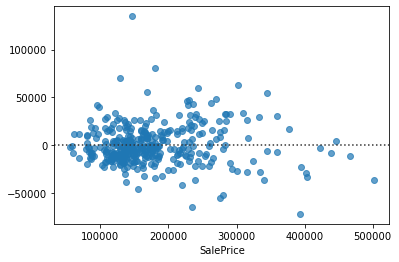

In [9]:
sns.residplot(x=y_test, y=y_hat, order=1, scatter_kws={'alpha':0.7})

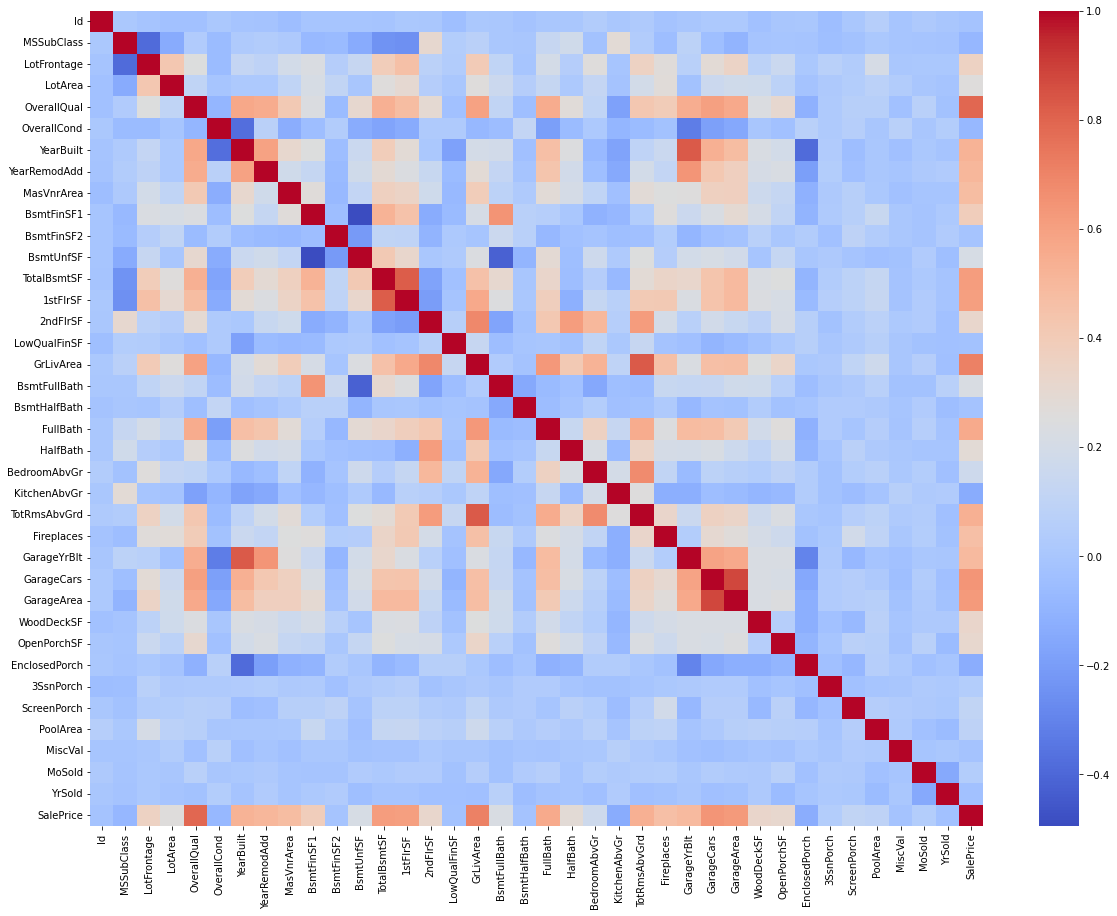

In [10]:
plt.figure(figsize=(20,15))
axs = sns.heatmap(train_data.corr(), cmap="coolwarm")

In [26]:
barv = [(i,x) for i,x in enumerate(pipe['model'].feature_importances_)]
barv.sort(key = lambda y:y[1], reverse=True)
print(barv[:20])

[(4, 0.5265722291360356), (16, 0.11521226874035846), (14, 0.05644741918654546), (12, 0.038382835858863186), (9, 0.027110717765796176), (13, 0.026016548038187145), (26, 0.021851651394917158), (27, 0.019691266985952256), (19, 0.014687664033064757), (3, 0.011782761145168536), (6, 0.010642820464754578), (23, 0.009090238168027918), (2, 0.008183808427252885), (7, 0.007111403771700289), (11, 0.0051883112748950634), (8, 0.004758041419605055), (29, 0.004660897824371457), (25, 0.004425646443798482), (28, 0.004306286373963559), (184, 0.00426466378061692)]


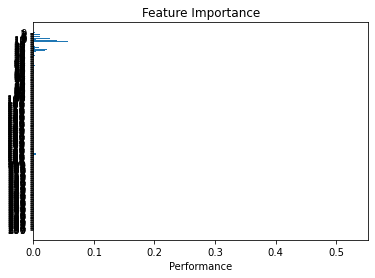

In [17]:
barx = np.arange(pipe['model'].n_features_in_)
barv = pipe['model'].feature_importances_

fig, ax = plt.subplots()
ax.barh(barx,barv)
ax.set_yticks(barx)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Feature Importance');